In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/My Drive/Research/SAnet/yolov5/yolov5'

/content/drive/My Drive/Research/SAnet/yolov5/yolov5


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# Any results you write to the current directory are saved as output.

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

## Bounding box detection


In [ ]:
import argparse

import torch.backends.cudnn as cudnn
from google.colab.patches import cv2_imshow
from utils import google_utils
from utils.datasets import *
from utils.utils import *

import glob
import math
import os
import random
import shutil
import time
from pathlib import Path
from threading import Thread

import cv2
import numpy as np
import torch
from PIL import Image, ExifTags
from torch.utils.data import Dataset
from tqdm import tqdm

from utils.utils import xyxy2xywh, xywh2xyxy

help_url = 'https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data'
img_formats = ['.bmp', '.jpg', '.jpeg', '.png', '.tif', '.dng']
vid_formats = ['.mov', '.avi', '.mp4', '.mpg', '.mpeg', '.m4v', '.wmv', '.mkv']



class LoadImages1:  # for inference
    def __init__(self, path, session, img_size=416):
        path = str(Path(path))  # os-agnostic
        files = []
        if os.path.isdir(path):
            files = sorted(glob.glob(os.path.join(path, '*.*')))
        elif os.path.isfile(path):
            files = [path]

        # images = [x for x in files if os.path.splitext(x)[-1].lower() in img_formats]
        images = []
        if session == 'session1':          
            for i in range(353):
                images.append(os.path.join(path,'session1 ('+str(i+1)+').jpg') )

        elif session == 'session2':          
            for i in range(386):
                images.append(os.path.join(path,'session2 ('+str(i+1)+').jpg') )


        videos = [x for x in files if os.path.splitext(x)[-1].lower() in vid_formats]
        nI, nV = len(images), len(videos)

        self.img_size = img_size
        self.files = images + videos
        self.nF = nI + nV  # number of files
        self.video_flag = [False] * nI + [True] * nV
        self.mode = 'images'
        if any(videos):
            self.new_video(videos[0])  # new video
        else:
            self.cap = None
        assert self.nF > 0, 'No images or videos found in %s. Supported formats are:\nimages: %s\nvideos: %s' % \
                            (path, img_formats, vid_formats)

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count == self.nF:
            raise StopIteration
        path = self.files[self.count]

        if self.video_flag[self.count]:
            # Read video
            self.mode = 'video'
            ret_val, img0 = self.cap.read()
            if not ret_val:
                self.count += 1
                self.cap.release()
                if self.count == self.nF:  # last video
                    raise StopIteration
                else:
                    path = self.files[self.count]
                    self.new_video(path)
                    ret_val, img0 = self.cap.read()

            self.frame += 1
            print('video %g/%g (%g/%g) %s: ' % (self.count + 1, self.nF, self.frame, self.nframes, path), end='')

        else:
            # Read image
            self.count += 1
            img0 = cv2.imread(path)  # BGR
            assert img0 is not None, 'Image Not Found ' + path
            print('image %g/%g %s: ' % (self.count, self.nF, path), end='')

        # Padded resize
        img = letterbox(img0, new_shape=self.img_size)[0]

        # Convert
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)

        # cv2.imwrite(path + '.letterbox.jpg', 255 * img.transpose((1, 2, 0))[:, :, ::-1])  # save letterbox image
        return path, img, img0, self.cap

    def new_video(self, path):
        self.frame = 0
        self.cap = cv2.VideoCapture(path)
        self.nframes = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def __len__(self):
        return self.nF  # number of files







def detect(source_path,session,save_img=False):
    out, source, weights, view_img, save_txt, imgsz = \
        opt.output, source_path, opt.weights, opt.view_img, opt.save_txt, opt.img_size
    webcam = source == '0' or source.startswith('rtsp') or source.startswith('http') or source.endswith('.txt')

    # Initialize
    device = torch_utils.select_device(opt.device)
    if os.path.exists(out):
        shutil.rmtree(out)  # delete output folder
    os.makedirs(out)  # make new output folder
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    google_utils.attempt_download(weights)
    model = torch.load(weights, map_location=device)['model'].float()  # load to FP32
    # torch.save(torch.load(weights, map_location=device), weights)  # update model if SourceChangeWarning
    # model.fuse()
    model.to(device).eval()
    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = torch_utils.load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model'])  # load weights
        modelc.to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = True
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz)
    else:
        save_img = True
        dataset = LoadImages1(source, session, img_size=imgsz)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

    # Run inference
    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    _ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once
    bounding_boxes_all_images = []
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        pred = model(img, augment=opt.augment)[0]

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t2 = torch_utils.time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0 = path[i], '%g: ' % i, im0s[i].copy()
            else:
                p, s, im0 = path, '', im0s

            save_path = str(Path(out) / Path(p).name)
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += '%g %ss, ' % (n, names[int(c)])  # add to string

                # Write results
                minx = 0 
                miny = 0
                maxx = 0
                maxy = 0

                box_num = 0
                bounding_boxes = {}
                for *xyxy, conf, cls in det:
                    box_num+=1
                    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                    #print("Box num:", box_num, " label: ",names[int(cls)], " xyxy: ", int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3]), "xywh: ", float(xywh[0]), float(xywh[1]), float(xywh[2]), float(xywh[3]))
                    if (bounding_boxes.get(names[int(cls)], None) == None):
                        bounding_boxes[names[int(cls)]] = [[float(xywh[0]), float(xywh[1]), float(xywh[2]), float(xywh[3])]]
                    else:
                        bounding_boxes[names[int(cls)]].append([float(xywh[0]), float(xywh[1]), float(xywh[2]), float(xywh[3])])


                    tlx,tly, brx, bry = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])
                    if tlx < minx: 
                        minx = tlx 
                    if tly < miny:
                        miny = tly
                    if bry > maxy:
                        maxy = bry
                    if brx > maxx:
                        maxx = brx #crop_img = img[y:y+h, x:x+w]


                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        with open(save_path[:save_path.rfind('.')] + '.txt', 'a') as file:
                            file.write(('%g ' * 5 + '\n') % (cls, *xywh))  # label format

                    if save_img or view_img:  # Add bbox to image
                        label = '%s %.2f' % (names[int(cls)], conf)
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
            bounding_boxes_all_images.append(bounding_boxes)    
            # Print time (inference + NMS)
            print('%sDone. (%.3fs)' % (s, t2 - t1))
            #im0 = im0[miny:maxy, minx:maxx]


            # Stream results
            if view_img:
                cv2_imshow( im0)
                not_showing = True
                #cv2.imshow(p, im0)
                
                if cv2.waitKey(1) == ord('q'):  # q to quit
                    raise StopIteration

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'images':
                    #cv2.imwrite(save_path, im0)
                    not_saving = True
                else:
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer

                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*opt.fourcc), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        print('Results saved to %s' % os.getcwd() + os.sep + out)
        if platform == 'darwin':  # MacOS
            os.system('open ' + save_path)

    print('Done. (%.3fs)' % (time.time() - t0))
    return bounding_boxes_all_images

######################################################################################

class Options:
    def __init__(self):
      self.weights = 'weights/best.pt'
      self.source = 'inference/images'
      self.output = 'inference/output'
      self.img_size = 640
      self.conf_thres = 0.4
      self.iou_thres = 0.5
      self.fourcc = 'mp4v'
      self.device = ''
      self.view_img = True
      self.agnostic_nms = False
      self.augment = False      
      self.save_txt = False
      self.classes = None

opt = Options()
# # if __name__ == '__main__':
# parser = argparse.ArgumentParser()
# parser.add_argument('--weights', type=str, default='weights/yolov5s.pt', help='model.pt path')
# parser.add_argument('--source', type=str, default='inference/images', help='source')  # file/folder, 0 for webcam
# parser.add_argument('--output', type=str, default='inference/output', help='output folder')  # output folder
# parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
# parser.add_argument('--conf-thres', type=float, default=0.4, help='object confidence threshold')
# parser.add_argument('--iou-thres', type=float, default=0.5, help='IOU threshold for NMS')
# parser.add_argument('--fourcc', type=str, default='mp4v', help='output video codec (verify ffmpeg support)')
# parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
# parser.add_argument('--view-img', action='store_true', help='display results')
# parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
# parser.add_argument('--classes', nargs='+', type=int, help='filter by class')
# parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
# parser.add_argument('--augment', action='store_true', help='augmented inference')
# opt = parser.parse_args()
opt.img_size = check_img_size(opt.img_size)
print(opt)

opt.weights='weights/best.pt'
opt.view_img=False

# det_bboxes = None
# source_path = 'inference/images/session2 (210).jpg'
source_path = '../../jpg_files'
# with torch.no_grad():
#     det_bboxes = detect(source_path,'session1')

        # Update all models
        # for opt.weights in ['yolov5s.pt', 'yolov5m.pt', 'yolov5l.pt', 'yolov5x.pt', 'yolov3-spp.pt']:
        #    detect()
        #    create_pretrained(opt.weights, opt.weights)


## Device selection
Select your device, whether you to use CPU or GPU for your model.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
!nvidia-smi

Tue Sep 29 04:46:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   3319MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls


 data				    __pycache__		   train_batch0.jpg
 detect.py			    README.md		   train_batch1.jpg
 Dockerfile			    requirements.txt	   train_batch2.jpg
 hubconf.py			    results.png		   train.py
 inference			    results.txt		  'Tutorial 2.ipynb'
 labels.png			    runs		   tutorial.ipynb
 LICENSE			    script.sh		   utils
 model_classification_tutorial.pt   source		   v1.ipynb
 models				    test_batch0_gt.jpg	   v2.ipynb
 output				    test_batch0_pred.jpg   weights
 output.log			    test.py


In [ ]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [ ]:
### Detect bboxes for session1 and session2
### Load detected boxes for session 1
det_boxes_session1 = []
det_boxes_session2 = []

# BASE_PATH = './'
ANNO_PATH = '../../annos/'
DATA_PATH = '../../jpg_files/'

with torch.no_grad():
    # det_boxes_session1
    source_path = DATA_PATH #os.path.join(DATA_PATH,'session1 ('+str(i+1)+').jpg')
    det_boxes_session1 = detect(source_path, 'session1')

    source_path = DATA_PATH #os.path.join(DATA_PATH,'session2 ('+str(i+1)+').jpg')
    det_boxes_session2 = detect(source_path, 'session2')

Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute o

image 1/353 ../../jpg_files/session1 (1).jpg: 

/content/drive/My Drive/Research/SAnet/yolov5/yolov5/utils/utils.py:580: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  i, j = (x[:, 5:] > conf_thres).nonzero().t()


384x640 3 blemisheds, 7 unblemisheds, 1 gloves, 1 belts, 1 bins, 1 heads, Done. (0.325s)
image 2/353 ../../jpg_files/session1 (2).jpg: 384x640 3 blemisheds, 7 unblemisheds, 1 gloves, 1 belts, 1 bins, 1 heads, Done. (0.040s)
image 3/353 ../../jpg_files/session1 (3).jpg: 384x640 4 blemisheds, 6 unblemisheds, 1 gloves, 1 belts, 1 bins, 1 heads, Done. (0.040s)
image 4/353 ../../jpg_files/session1 (4).jpg: 384x640 4 blemisheds, 6 unblemisheds, 1 gloves, 1 belts, 1 bins, 1 heads, Done. (0.040s)
image 5/353 ../../jpg_files/session1 (5).jpg: 384x640 4 blemisheds, 7 unblemisheds, 1 gloves, 1 belts, 1 bins, 1 heads, Done. (0.040s)
image 6/353 ../../jpg_files/session1 (6).jpg: 384x640 4 blemisheds, 7 unblemisheds, 1 gloves, 1 belts, 1 bins, 1 heads, Done. (0.040s)
image 7/353 ../../jpg_files/session1 (7).jpg: 384x640 4 blemisheds, 6 unblemisheds, 1 gloves, 1 belts, 1 bins, 1 heads, Done. (0.040s)
image 8/353 ../../jpg_files/session1 (8).jpg: 384x640 4 blemisheds, 6 unblemisheds, 1 gloves, 1 belts

In [ ]:
BASE_PATH = './'

In [ ]:
!ls ../../annos/

data_session1_annos.csv  data_session2_annos.csv


In [ ]:
df_csv = pd.read_csv('../../annos/data_session1_annos.csv')
df_csv.head()

,Image,O_loc,EE_loc,Prediction,Action
0,1,0,3,1,7
1,2,0,3,1,7
2,3,0,0,1,3
3,4,0,0,1,3
4,5,0,0,1,3


In [ ]:
df_csv = pd.read_csv('../../annos/data_session1_annos.csv')
data = pd.DataFrame()
data['Images'] = 'session1 ('+df_csv['Image'].astype(str)+').jpg'
data['EE_labels'] = df_csv['EE_loc']
data['O_labels'] = df_csv['O_loc']
data['P_labels'] = df_csv['Prediction']
data.head()

,Images,EE_labels,O_labels,P_labels
0,session1 (1).jpg,3,0,1
1,session1 (2).jpg,3,0,1
2,session1 (3).jpg,0,0,1
3,session1 (4).jpg,0,0,1
4,session1 (5).jpg,0,0,1


In [ ]:
data.loc[:,['EE_labels','O_labels','P_labels']].head()

,EE_labels,O_labels,P_labels
0,3,0,1
1,3,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [ ]:
data.loc[:,['P_labels']].min()

P_labels    0
dtype: int64

In [ ]:
# lb = LabelEncoder()
# data['encoded_labels'] = lb.fit_transform(data['labels'])
# data.head()
# data['encoded_labels'] = data['labels']
# data.head()

## Spliting of Dataset
I have shown two ways to split a dataset into train and validation. One is by splitting it from sratch and another method is by using train_test_split from scikit-learn( the one which I have commented out).

In [ ]:
batch_size = 32
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [ ]:
# Creating data indices for training and validation splits:
# from sklearn.model_selection import train_test_split
# tr, val = train_test_split(data.label, stratify=data.label, test_size=0.1)
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#train_indices is equivalent to list(tr.index)
#val_indices is equivalent to list(val.index)

In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Transforms
Transforms are common image transformations. They can be chained together using **Compose**.
## Normalization
Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]
Convert a PIL Image or numpy.ndarray to tensor.

## ToTensor
Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

 ## Create custom dataset class
 A dataset must contain following functions to be used by data loader later on.

* __init__() function is where the initial logic happens like reading a csv, assigning transforms etc.
* __getitem__() function returns the data and labels. This function is called from dataloader like this:

> img, label = MyCustomDataset.__getitem__(99)  # For 99th item

<br>
An important thing to note is that __getitem__() return a specific type for a single data point (like a tensor, numpy array etc.), otherwise, in the data loader you will get an error like:

> TypeError: batch must contain tensors, numbers, dicts or lists; found 
> class 'PIL.PngImagePlugin.PngImageFile'

<br>
Credits: [PyTorch Custom Dataset Examples](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)

In [ ]:
class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None, det_boxes = []):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        self.det_boxes = det_boxes
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,#self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((640,480))
        label = torch.tensor(self.img_data.loc[index,['EE_labels','O_labels','P_labels']])
        if self.transform is not None:
            image = self.transform(image)

        bb = torch.zeros(44)
        # det_boxes_session1[0][0]
        start_ind = 0
        if self.det_boxes[index].get('glove',None) != None:
            bb[40:44] = torch.Tensor(self.det_boxes[index]['glove'][0])
        if self.det_boxes[index].get('unblemished',None) != None:
            end_ind = start_ind + len(self.det_boxes[index]['unblemished'])*4
            bb[start_ind:end_ind] = torch.Tensor(self.det_boxes[index]['unblemished']).view(1,-1)
            start_ind = end_ind
        if self.det_boxes[index].get('blemished',None) != None:
            end_ind = 40
            start_ind = 40 - len(self.det_boxes[index]['blemished'])*4
            bb[start_ind:end_ind] = torch.Tensor(self.det_boxes[index]['blemished']).view(1,-1)
            start_ind = end_ind
        # print("image.shape:::::",image.shape)
        return image, bb, label

In [1]:
import torch


**NOTE** - In case you already have a separate dataset set for train and validation, you could directly pass the path of the datasets to the __init__ section of the custom dataset class and read it right there and use it.

In [ ]:
img_path = os.path.join('../../jpg_files')

dataset = Arthopod_Dataset(data,img_path,transform, det_boxes_session1)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [ ]:
# # get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# arthopod_types = {0: 'at conveyor', 1: 'in front of eye', 2: 'at bin', 3: 'at hover plane'}
# # Viewing data examples used for training
# fig, axis = plt.subplots(3, 5, figsize=(15, 10))
# for i, ax in enumerate(axis.flat):
#     with torch.no_grad():
#         image, label = images[i], labels[i]
#         ax.imshow(img_display(image)) # add image
#         ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
# fig, axis = plt.subplots(3, 5, figsize=(15, 10))
# for i, ax in enumerate(axis.flat):
#     print(i)

## The Neural Network
In the **Net** class created below, we have constructed a neural network. Construction of the neural network was the second most difficult situation that I faced after constructing a custom dataset. But I am going to explain you everything step by step.<br>
* Inside the **init()** method you declare each layer with a unique layer name. For every unique layer, declaring its input features and output features is a must. At least the input feature is a must for some of the layers like batch normalization.
* Inside the **forward(self, x)** method you need to connect the layers that were declared in the init method. One thing must be kept in mind that the output feature of one layer is an input feature of its next connecting layer.


In [ ]:
class Net(nn.Module):
    # def __init__(self):
    #     super(Net, self).__init__()
    #     # 3 input image channel, 16 output channels, 3x3 square convolution kernel
    #     self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
    #     self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
    #     self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
    #     self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
    #     self.pool = nn.MaxPool2d(2, 2)
    #     self.dropout = nn.Dropout2d(0.4)
    #     self.batchnorm1 = nn.BatchNorm2d(16)
    #     self.batchnorm2 = nn.BatchNorm2d(32)
    #     self.batchnorm3 = nn.BatchNorm2d(64)
    #     self.fc1 = nn.Linear(64*8*10,512 )
    #     self.fc2 = nn.Linear(512, 256)
    #     self.fc3 = nn.Linear(256, 4)

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,9), stride=1)
        self.pool1 = nn.MaxPool2d(4, 3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,9), stride=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,9), stride=1)
        self.pool2 = nn.MaxPool2d(2, 3)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,9), stride=1)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=(3,9), stride=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1_1 = nn.Linear((32*24*24)+44, 128) ### for input shape: [1, 3, 480, 640], the output shape is: [1, 32, 24, 24] and then we concat 44 bounding box
        self.fc1_2 = nn.Linear(128, 64) # Change input dimension
        self.fc1_3 = nn.Linear(64, 32) # Change input dimension
        self.fc1_4 = nn.Linear(32, 4) # Change input  # for ee_loc
        self.fc1_5 = nn.Linear(32, 5) # Change input  # for o_loc
        self.fc1_6 = nn.Linear(32, 2) # Change input  # for p_label

        
    def forward(self, x, x_bb):
    #     x = self.batchnorm1(F.relu(self.conv1(x)))
    #     x = self.batchnorm2(F.relu(self.conv2(x)))
    #     x = self.dropout(self.batchnorm2(self.pool(x)))
    #     x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
    #     x = self.dropout(self.conv4(x))
    #     x = x.view(-1, 64*8*10) # Flatten layer
    #     x = self.dropout(self.fc1(x))
    #     x = self.dropout(self.fc2(x))
    #     x = F.log_softmax(self.fc3(x),dim = 1)
    #     return x
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool3(x) ### for input shape: [1, 3, 480, 640], the output shape is: [1, 32, 24, 24]
        
        # print("Shape of x::::", x.shape)
        x = x.view(-1, 32*24*24) # Flatten layer
        # print("x[0,:]::::::::",x[0,:])
        # print("Shape of x::::", x.shape, "Shape of x_bb::::", x_bb.shape)
        x = torch.cat((x, x_bb),1)
        # x = x.view()
        x = self.fc1_1(x)
        x = self.fc1_2(x)
        x = self.fc1_3(x)
        x1 = self.fc1_4(x) ## for ee_loc
        x2 = self.fc1_5(x) ## for o_loc
        x3 = self.fc1_6(x) ## for p_label
        x1 = F.softmax(x1,dim = 1)
        x2 = F.softmax(x2,dim = 1)
        x3 = F.softmax(x3,dim = 1)
        return x1,x2, x3

In [ ]:
# model = Net() # On CPU
model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 9), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 9), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 9), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 32, kernel_size=(3, 9), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 9), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1_1): Linear(in_features=18476, out_features=128, bias=True)
  (fc1_2): Linear(in_features=128, out_features=64, bias=True)
  (fc1_3): Linear(in_features=64, out_features=32, bias=True)
  (fc1_4): Linear(in_features=32, out_features=4, bias=True)
  (fc1_5): Linear(in_features=32, out_features=5, bias=True)
  (fc1_6): Linear(in_features=32, out_features=2, bias=True)
)


## CrossEntropyLoss

It is useful when training a classification problem with C classes. If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set. It is a prototpe of categorical crossentropy in keras.
In case of **Binary classification** use **BCELoss(Binary Cross Entropy)** or BCEWithLogitsLoss.

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
a1 = torch.rand(1,4)
a2 = torch.rand(1,4)
print( a1, a2)
torch.cat((a1, a2),1)

tensor([[0.54291, 0.06652, 0.07041, 0.83760]]) tensor([[0.58935, 0.17434, 0.27177, 0.04459]])


tensor([[0.54291, 0.06652, 0.07041, 0.83760, 0.58935, 0.17434, 0.27177, 0.04459]])

## Training the Network
In the cell below, it is explained how to train your model with epochs. In the "train_loss" and "val_loss" the training loss and validation loss are stored respectively after every epoch. Similarly in case of training accuracy and validation accuracy also, the same thing happens. just remember while validation the weighhts are not upgraded thats why we use **" with torch.no_grad() "**.<br>
Here, **"Torch.max(x, dim=1)"** works same as **"np.argmax(x, axis=1)"**. We use **".item()"** to get the value inside the tensor. **torch.save(model.state_dict(), 'model_classification_tutorial.pt')** is used to save the PyTorch weight in the given directory.

In [ ]:
n_epochs = 40
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc1 = []
val_acc2 = []
val_acc3 = []
train_loss = []
train_acc1 = []
train_acc2 = []
train_acc3 = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct1 = 0
    correct2 = 0
    correct3 = 0
    total1=0
    total2=0
    total3=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, bb_, target_) in enumerate(train_loader):
        data_, bb_, target_ = data_.to(device), bb_.to(device), target_.to(device)# on GPU
        # print("target_.shape:::",target_.shape)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs1, outputs2, outputs3 = model(data_, bb_)
        loss1 = criterion(outputs1, target_[:,0])
        loss2 = criterion(outputs2, target_[:,1])
        loss3 = criterion(outputs3, target_[:,2])
        loss = loss1 + loss2 + loss3
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred1 = torch.max(outputs1, dim=1)
        _,pred2 = torch.max(outputs2, dim=1)
        _,pred3 = torch.max(outputs3, dim=1)
        correct1 += torch.sum(pred1==target_[:,0]).item()
        correct2 += torch.sum(pred2==target_[:,1]).item()
        correct3 += torch.sum(pred3==target_[:,2]).item()
        total1 += target_[:,0].size(0)
        total2 += target_[:,1].size(0)
        total3 += target_[:,2].size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc1.append(100 * correct1 / total1)
    train_acc2.append(100 * correct2 / total2)
    train_acc3.append(100 * correct3 / total3)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc1: {(100 * correct1 / total1):.4f}, train acc2: {(100 * correct2 / total2):.4f}, train acc3: {(100 * correct3 / total3):.4f}')
    batch_loss = 0
    total_t1=0
    total_t2=0
    total_t3=0
    correct_t1=0
    correct_t2=0
    correct_t3=0
    with torch.no_grad():
        model.eval()
        for data_t, bb_t, target_t in (validation_loader):
            data_t, bb_t, target_t = data_t.to(device), bb_t.to(device), target_t.to(device)# on GPU
            outputs_t1, outputs_t2, outputs_t3 = model(data_t, bb_t)
            loss_t1 = criterion(outputs_t1, target_t[:,0])
            loss_t2 = criterion(outputs_t2, target_t[:,1])
            loss_t3 = criterion(outputs_t3, target_t[:,2])
            loss_t = loss_t1 + loss_t2 + loss_t3
            batch_loss += loss_t.item()
            _,pred_t1 = torch.max(outputs_t1, dim=1)
            _,pred_t2 = torch.max(outputs_t2, dim=1)
            _,pred_t3 = torch.max(outputs_t3, dim=1)
            correct_t1 += torch.sum(pred_t1==target_t[:,0]).item()
            correct_t2 += torch.sum(pred_t2==target_t[:,1]).item()
            correct_t3 += torch.sum(pred_t3==target_t[:,2]).item()
            total_t1 += target_t[:,0].size(0)
            total_t2 += target_t[:,1].size(0)
            total_t3 += target_t[:,2].size(0)
        # print("Eval::::correct_t1,total_t1", correct_t1, total_t1 )
        val_acc1.append(100 * correct_t1 / total_t1)
        val_acc2.append(100 * correct_t2 / total_t2)
        val_acc3.append(100 * correct_t3 / total_t3)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc1: {(100 * correct_t1 / total_t1):.4f}, validation acc2: {(100 * correct_t2 / total_t2):.4f}, validation acc3: {(100 * correct_t3 / total_t3):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/40], Step [0/8], Loss: 3.6886

train loss: 3.6958, train acc1: 32.6613, train acc2: 2.0161, train acc3: 55.6452
validation loss: 3.7042, validation acc1: 25.7143, validation acc2: 0.9524, validation acc3: 55.2381

Detected network improvement, saving current model
Epoch 2

Epoch [2/40], Step [0/8], Loss: 3.6960

train loss: 3.6946, train acc1: 32.6613, train acc2: 2.0161, train acc3: 55.6452
validation loss: 3.7020, validation acc1: 25.7143, validation acc2: 0.9524, validation acc3: 55.2381

Detected network improvement, saving current model
Epoch 3

Epoch [3/40], Step [0/8], Loss: 3.6821

train loss: 3.6932, train acc1: 32.6613, train acc2: 2.0161, train acc3: 55.6452
validation loss: 3.6991, validation acc1: 25.7143, validation acc2: 0.9524, validation acc3: 55.2381

Detected network improvement, saving current model
Epoch 4

Epoch [4/40], Step [0/8], Loss: 3.6898

train loss: 3.6915, train acc1: 32.6613, train acc2: 2.0161, train acc3: 55.6452
validation loss: 3.69

In [ ]:
# import glob
# import os
# # import path
# session = 'session1'
# path = '../../jpg_files'
# sorted(glob.glob(os.path.join(path, session+'*.*')))

## Accuracy and loss Curve

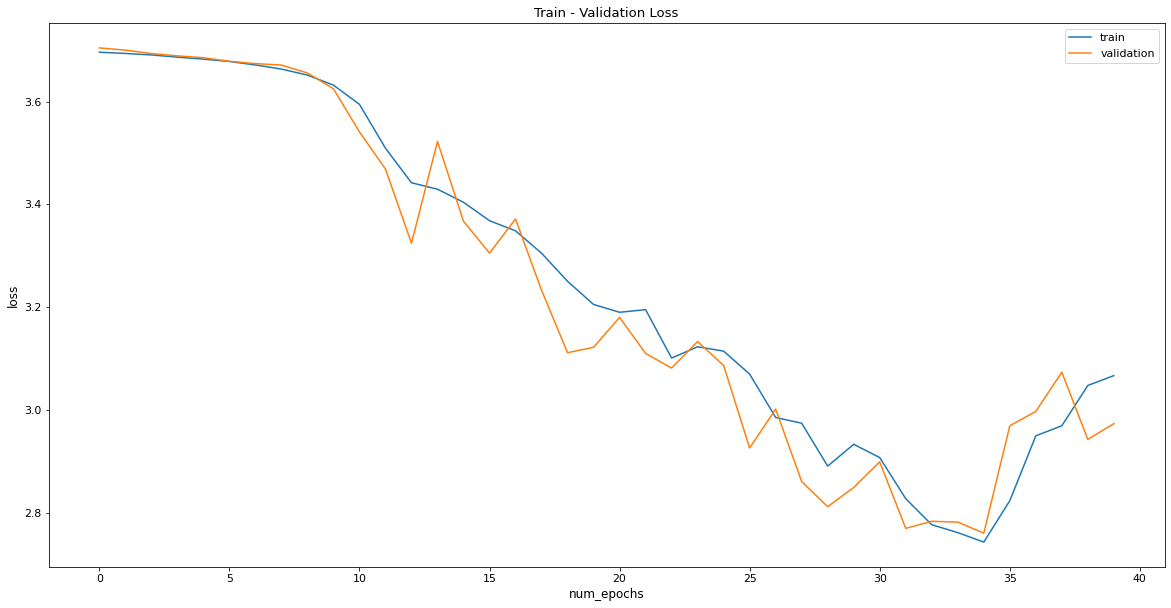

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

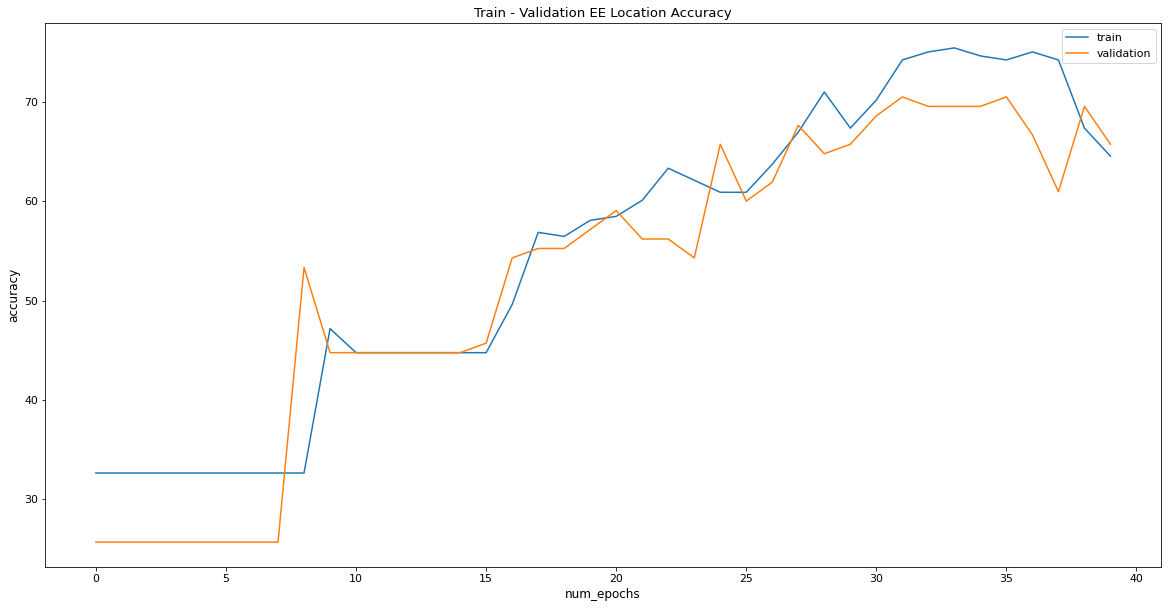

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation EE Location Accuracy")
plt.plot(train_acc1, label='train')
plt.plot(val_acc1, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

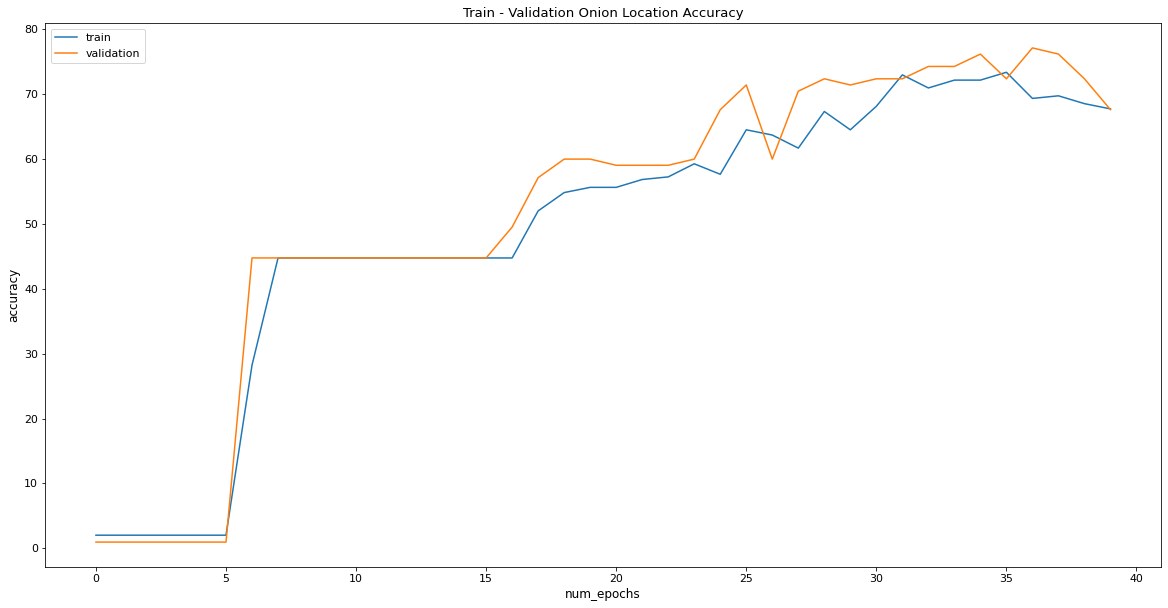

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Onion Location Accuracy")
plt.plot(train_acc2, label='train')
plt.plot(val_acc2, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

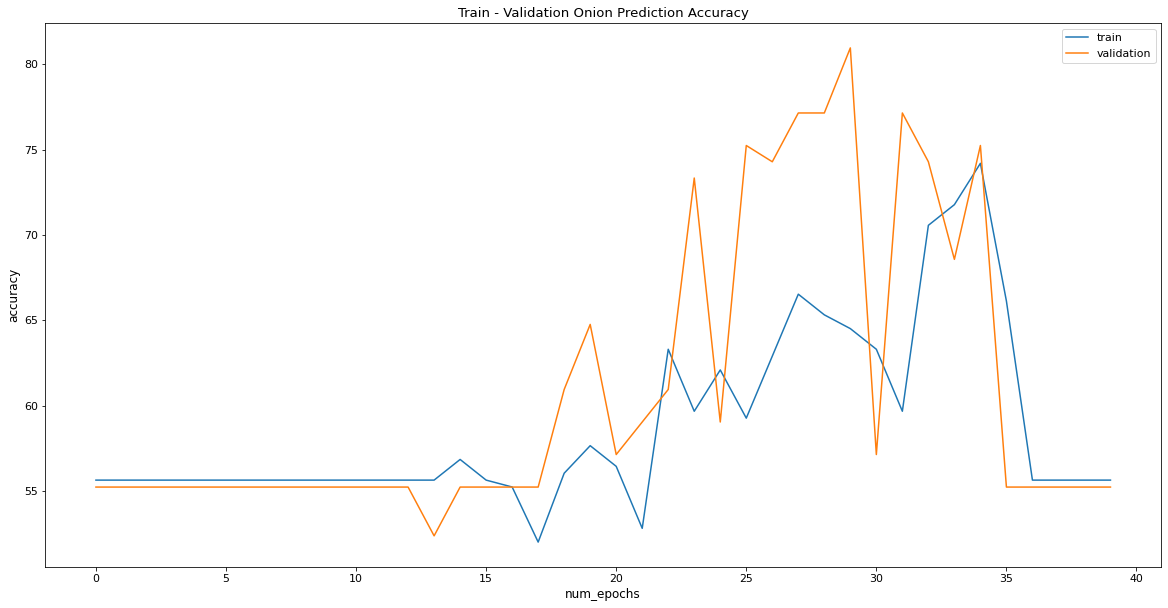

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Onion Prediction Accuracy")
plt.plot(train_acc3, label='train')
plt.plot(val_acc3, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

<All keys matched successfully>

## Evaluation
evaluating the model performance through visualization

In [ ]:
df_csv_test = pd.read_csv('../../annos/data_session2_annos.csv')
data_test = pd.DataFrame()
data_test['Images'] = 'session2 ('+df_csv_test['Image'].astype(str)+').jpg'
data_test['EE_labels'] = df_csv_test['EE_loc']
data_test['O_labels'] = df_csv_test['O_loc']
data_test['P_labels'] = df_csv_test['Prediction']
data_test.head()

,Images,EE_labels,O_labels,P_labels
0,session2 (1).jpg,3,0,1
1,session2 (2).jpg,3,0,1
2,session2 (3).jpg,0,0,1
3,session2 (4).jpg,0,0,1
4,session2 (5).jpg,0,0,1


In [ ]:
from torch.utils.data.sampler import SequentialSampler
test_dataset_size = len(data_test)
test_indices = list(range(test_dataset_size))
test_sampler = SequentialSampler(test_indices)

In [ ]:
test_dataset = Arthopod_Dataset(data_test,img_path,transform, det_boxes_session2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
# val_loss = []
test_acc1 = []
test_acc2 = []
test_acc3 = []

total_t1=0
total_t2=0
total_t3=0
correct_t1=0
correct_t2=0
correct_t3=0

allpreds1 = torch.rand(0)
allpreds2 = torch.rand(0)
allpreds3 = torch.rand(0)

allpreds1 = allpreds1.to(device)
allpreds2 = allpreds2.to(device)
allpreds3 = allpreds3.to(device)

with torch.no_grad():
    model.eval()
    for data_t, bb_t, target_t in (test_loader):
        data_t, bb_t, target_t = data_t.to(device), bb_t.to(device), target_t.to(device)# on GPU
        outputs_t1, outputs_t2, outputs_t3 = model(data_t, bb_t)
        # loss_t1 = criterion(outputs_t1, target_t[:,0])
        # loss_t2 = criterion(outputs_t2, target_t[:,1])
        # loss_t3 = criterion(outputs_t3, target_t[:,2])
        # loss_t = loss_t1 + loss_t2 + loss_t3
        # batch_loss += loss_t.item()
        _,pred_t1 = torch.max(outputs_t1, dim=1)
        # print(pred_t1.shape)
        _,pred_t2 = torch.max(outputs_t2, dim=1)
        _,pred_t3 = torch.max(outputs_t3, dim=1)

        allpreds1 = torch.cat((allpreds1,pred_t1),dim=0)
        allpreds2 = torch.cat((allpreds2,pred_t2),dim=0)
        allpreds3 = torch.cat((allpreds3,pred_t3),dim=0)

        correct_t1 += torch.sum(pred_t1==target_t[:,0]).item()
        correct_t2 += torch.sum(pred_t2==target_t[:,1]).item()
        correct_t3 += torch.sum(pred_t3==target_t[:,2]).item()
        total_t1 += target_t[:,0].size(0)
        total_t2 += target_t[:,1].size(0)
        total_t3 += target_t[:,2].size(0)
    # print("Eval::::correct_t1,total_t1", correct_t1, total_t1 )
    test_acc1.append(100 * correct_t1 / total_t1)
    test_acc2.append(100 * correct_t2 / total_t2)
    test_acc3.append(100 * correct_t3 / total_t3)
    # val_loss.append(batch_loss/len(validation_loader))
    # network_learned = batch_loss < valid_loss_min
    print(f'test acc1: {(100 * correct_t1 / total_t1):.4f}, test acc2: {(100 * correct_t2 / total_t2):.4f}, test acc3: {(100 * correct_t3 / total_t3):.4f}\n')


test acc1: 55.1813, test acc2: 46.1140, test acc3: 47.6684



In [ ]:
allpreds3

tensor([0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
cpu_device = torch.device("cpu")
allpreds1 = allpreds1.to(cpu_device)
allpreds2 = allpreds2.to(cpu_device)
allpreds3 = allpreds3.to(cpu_device)

In [ ]:
# allpreds1.shape

In [ ]:
ee_loc_vals = {0.0: 'conveyor', 1.0: 'eye', 2.0:'bin', 3.0:'hover'}
o_loc_vals = {0.0: 'conveyor', 1.0: 'eye', 2.0:'bin', 3.0:'hover', 4.0:'placed'}
p_vals = {0.0:'blemished', 1.0:'unblemished'}

In [ ]:
!ls

 data				    __pycache__		   train_batch0.jpg
 detect.py			    README.md		   train_batch1.jpg
 Dockerfile			    requirements.txt	   train_batch2.jpg
 hubconf.py			    results.png		   train.py
 inference			    results.txt		  'Tutorial 2.ipynb'
 labels.png			    runs		   tutorial.ipynb
 LICENSE			    script.sh		   utils
 model_classification_tutorial.pt   source		   v1.ipynb
 models				    test_batch0_gt.jpg	   v2.ipynb
 output				    test_batch0_pred.jpg   weights
 output.log			    test.py


In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (700,60)
fontScale              = 1
fontColor              = (255,0,0)
lineType               = 2

out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 2, (1920,1080))
 
# for i in range(len(img_array)):
    


for i in range(386):
  print(i)
  img_name = '../../jpg_files/session2 ('+str(i+1)+').jpg'
  img = cv2.imread(img_name)
  i1 = allpreds1[i].item()
  i2 = allpreds2[i].item()
  i3 = allpreds3[i].item()
  tag = 'Frame: '+str(i+1)+' EE loc: '+ee_loc_vals[i1]+' Onion loc: '+o_loc_vals[i2]+' Prediction: '+p_vals[i3]
  cv2.putText(img,tag, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
  out.write(img)
  # cv2_imshow(img)
out.release()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Create a black image
img = np.zeros((512,512,3), np.uint8)
img = cv2.imread('../../jpg_files/session2 (1).jpg')
# Write some Text

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (1500,50)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

cv2.putText(img,'Hello World!', 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

#Display the image
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
dev_props = [torch.cuda.get_device_properties(i) for i in device_ids]
print(dev_props)

NameError: ignored

In [ ]:
a1 = torch.rand(0)
a2 = torch.rand(7)
print(a1,a2)
torch.cat((a1,a2), dim=0)
a1.item()

tensor([]) tensor([0.21892, 0.93796, 0.64574, 0.78006, 0.41479, 0.27838, 0.58344])


ValueError: ignored

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
# arthopod_types = {0: 'Coleoptera', 1: 'Diptera', 2: 'Hymenoptera', 3: 'Lepidoptera'}
arthopod_types = {0: 'at conveyor', 1: 'in front of eye', 2: 'at bin', 3: 'at hover plane'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        image_tensor = image_tensor.to(device)#, target_t.to(device)# on GPU
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title('Actual:'+str(arthopod_types[label.item()])+" \nPredicted:" +str(arthopod_types[output_.item()])) # add label